In [1]:
%matplotlib widget
import emcee, copy
import numpy as np
from astropy.table import Table,Column
import matplotlib.pyplot as plt
from astropy.io import ascii

In [2]:
lc = [] 
err = [] 
times = [] 

In [3]:
with open('hgw_bol_lum', 'r') as f:
    lines = f.readlines()
    for line in lines:
        lc.append(float(line.strip()))

In [4]:
with open('hgw_bol_err', 'r') as f:
    lines = f.readlines()
    for line in lines:
        err.append(float(line.strip()))

In [5]:
with open('hgw_full_interp_times', 'r') as f:
    lines = f.readlines()
    for line in lines:
        times.append(float(line.strip()))

<ErrorbarContainer object of 3 artists>

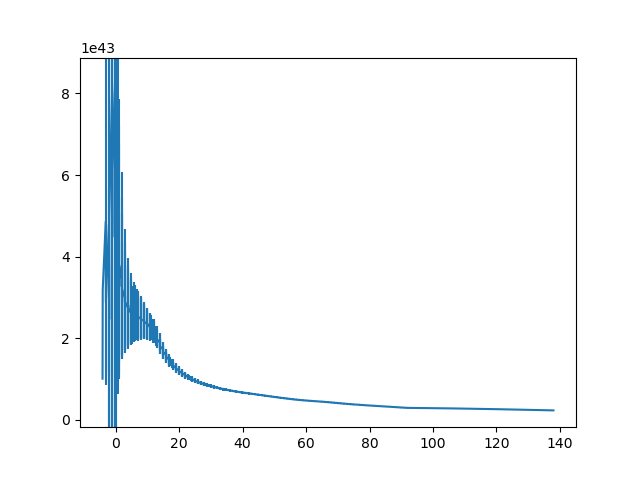

In [6]:
plt.errorbar(times, lc, yerr = err)

       MJD                  lum           ...         t_exp        
------------------ ---------------------- ... ---------------------
25.002999999996973  9.530270019115764e+42 ... 0.0029999999969732016
25.872000000003027  9.357667107822797e+42 ...    0.8720000000030268
25.919000000001688  9.377896831288831e+42 ...     0.919000000001688
25.929000000003725   9.39365631136739e+42 ...    0.9290000000037253
25.955999999998312  9.156802364884586e+42 ...     0.955999999998312
 25.95900000000256  9.158671855666073e+42 ...    0.9590000000025611
26.002999999996973   9.21078806235126e+42 ...    1.0029999999969732
26.872000000003027  9.054492510339038e+42 ...    1.8720000000030268
26.919000000001688  9.073245763542872e+42 ...     1.919000000001688
26.929000000003725  9.086954570335671e+42 ...    1.9290000000037253
               ...                    ... ...                   ...
127.95900000000256  2.481738510397159e+42 ...    102.95900000000256
128.95900000000256 2.4648818620059628e+42 ...   

  1%|          | 51/5000 [00:01<02:18, 35.83it/s]C:\Users\jvasq\AppData\Local\Temp\ipykernel_8876\1468663275.py:9: RuntimeWarning: overflow encountered in exp
  return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)
100%|██████████| 5000/5000 [02:03<00:00, 40.57it/s]


Best-fit parameters:
Param: 5.378438606671223 + 3.3837007197482674 - 3.9028850902252783
Param: 3.0436024833166637e+28 + 1.545480629296245e+42 - 3.0436024833166637e+28
Param: 5.248719184681572e+27 + 3.713580434718334e+41 - 5.248719184681572e+27
Param: 0.014834362962450685 + 0.00024223708914742313 - 0.00024334302678431265
Param: -13.219191643197577 + 3.353353214763189 - 3.907540810561157
[5.378438606671223, 3.0436024833166637e+28, 5.248719184681572e+27, 0.014834362962450685, -13.219191643197577]
       MJD                  lum           ...         t_exp        
------------------ ---------------------- ... ---------------------
25.002999999996973  9.530270019115764e+42 ... 0.0029999999969732016
25.872000000003027  9.357667107822797e+42 ...    0.8720000000030268
25.919000000001688  9.377896831288831e+42 ...     0.919000000001688
25.929000000003725   9.39365631136739e+42 ...    0.9290000000037253
25.955999999998312  9.156802364884586e+42 ...     0.955999999998312
 25.95900000000256  9.158

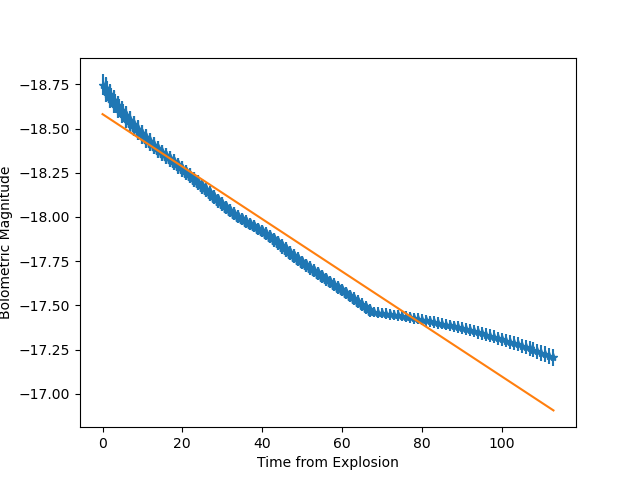

In [8]:
plt.clf()

# Input parameters - superbol file and MJD explosion/discovery date
data_file='hgw_combined_data'
mjd_start=25

def valenti_model(time, theta):
    a, tpt, w, p, m = theta
    return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)

def lnlikelihood(theta, lum, dlum, time):
    model_lum = valenti_model(time, theta)
    
    # Set parameter range value
    a, tpt, w, p, m = theta
    if a<0.01: return(-np.inf)
    if a>10.0: return(-np.inf)
    if tpt<10.0: return(-np.inf)
    if w<0.01: return(-np.inf)
    
    inv_sigma = 1./dlum**2
    return(-0.5 * np.sum((lum-model_lum)**2 * inv_sigma))

def load_table(data_file, mjd_start=mjd_start, mask_date=0):
    # The code will automatically mask data mask_date days from the input reference date.
    # Change this value in order to adjust the amount of data that's included/excluded
    
    table = Table.read(data_file, format='ascii',names=('MJD','lum','dlum'))
    #print(table)
    # Want to fit versus a magnitude rather than actual luminosity, so convert lum to Mbol
    # Here 83.9605452803 = 2.5*log10(3.839e33) for Solar luminosity
    # 4.74 is bolometric luminosity of the Sun
    table['MJD'] = table['MJD']
    Mbol = -2.5*np.log10(table['lum']) + 83.9605452803 + 4.74
    Mbolerr = 1.086 * (table['dlum'] / table['lum'])

    
    table.add_column(Column(Mbol, name='Mbol'))
    table.add_column(Column(Mbolerr, name='Mbolerr'))
    
    newcol=Column(table['MJD'].data-mjd_start,name='t_exp')
    table.add_column(newcol)
    
    mask = table['t_exp']>mask_date
    table=table[mask]
    print(table)
    return(table)

def mcmc_valenti(data_file, ndim=5, nwalkers=100, inflate_errors=0.1):
    
    # I'm adding a parameter to inflate the error bars because the code appears to underfit the
    # late time decline due to nickel, which is primarily what we're interested in
    
    params = [1.7391707763335567, 111.06179709805089, 7.203197652533321, 0.008194307783125725, -13.583601384015793]
    pos = [params + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
    
    table = load_table(data_file)
    mask = np.abs(table['MJD'] - 58923) < 1
    table = table[~mask]
    table['Mbolerr'] = np.sqrt(table['Mbolerr']**2+inflate_errors**2)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlikelihood, 
                                    args=(table['Mbol'],
                                          table['Mbolerr'],
                                          table['t_exp']))
    
    sampler.run_mcmc(pos, 5000, progress=True)
    samples = sampler.chain[:, 99:, :].reshape((-1, ndim))
    
    return(samples)

def get_param_uncertainties(samples):
    
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    
    vals = [v for v in vals]
    
    return(vals)
    
samples=mcmc_valenti(data_file)
params=get_param_uncertainties(samples)
   

print('Best-fit parameters:')
for p in copy.copy(params):
    print('Param: {0} + {1} - {2}'.format(p[0], p[1], p[2]))

best_fit=[p[0] for p in copy.copy(params)]
print(best_fit)
table = load_table(data_file)
plt.errorbar(table['MJD']-mjd_start, table['Mbol'], yerr=table['Mbolerr'], marker='*', zorder=5)

    
model_lum=valenti_model(table['MJD']-mjd_start, best_fit)

plt.plot(table['MJD']-mjd_start, model_lum, zorder=10)

#plt.ylim([-14,-20])
plt.ylabel('Bolometric Magnitude')
plt.xlabel('Time from Explosion')
plt.gca().invert_yaxis()

plt.show()

In [9]:
luminosity=[]
# Using 220.0 rest-frame days as reference time
lightcurve_ref_time = 220-mjd_start
print(lightcurve_ref_time)
for s in samples:
    abs_mag=valenti_model(lightcurve_ref_time, s)
    luminosity.append(3.839e33 * 10**(-0.4 * (abs_mag-4.74)))

data = np.percentile(luminosity, [16, 50, 84])
lum=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0] 
print('Luminosity (1e39 erg/s)=','%1.2f'%(lum*1.0e-39),'+','%1.2f'%(errhi*1.0e-39),'-','%1.2f'%(errlo*1.0e-39))
print(data) 
print(errhi)
print(errlo)

# Heating rate for Co-56 decay in erg/s/g
epsilon = 6.8e9
# Mass of Co-56 in grams at 270 days
mass_Co56 = np.array(luminosity) / epsilon

# Radioactive decay timescale for Ni-56 and Co-56.  These are equal to ln(2)/(half-life)
# Half-life for Ni-56 is 6.075 days, Half-life for Co-56 is 55.93983 days
lambda_Co56 = np.log(2)/55.9383
lambda_Ni56 = np.log(2)/6.075

# Mass of Ni-56 at t=0
mass_Ni56 = mass_Co56 * (lambda_Co56 - lambda_Ni56)/lambda_Ni56 * (np.exp(-lambda_Ni56 * lightcurve_ref_time) - np.exp(-lambda_Co56 * lightcurve_ref_time))**-1
data = np.percentile(mass_Ni56, [16, 50, 84])
print(data)
mass=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0] 
print('Mass (Msun)=','%1.4f'%(mass/(1.989e33)),'+','%1.4f'%(errhi/(1.989e33)),'-','%1.4f'%(errlo/(1.989e33)))

195


C:\Users\jvasq\AppData\Local\Temp\ipykernel_8876\1468663275.py:9: RuntimeWarning: overflow encountered in exp
  return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)


Luminosity (1e39 erg/s)= 553.98 + 20.12 - 20.96
[5.33016315e+41 5.53978654e+41 5.74101056e+41]
2.012240182712067e+40
2.0962339157989857e+40
[7.82868811e+32 8.13657289e+32 8.43212109e+32]
Mass (Msun)= 0.4091 + 0.0149 - 0.0155
